# Suite des Tests

## Fichiers csv

In [1]:
import pandas as pd
#Importation du fichier cs

#SL
#data = pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Deuxième jeux de données/SL/Charles_Goulet_14.11.23_SL/Tuesday Alpine Skiing at 12-35-detail.csv")
#data=pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Premier jeux de données/Synergie/Synergie/Thomas_Mckinlay_SL_14.11.24/Tuesday Alpine Skiing at 12-34-detail.csv")

#GS
#data = pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Deuxième jeux de données/GS/Lexis_cournoyer_15.11.23_GS/Wednesday Alpine Skiing - GS at 08-52-detail.csv")
#data = pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Deuxième jeux de données/GS/Charles-Antoine_Goulet_15.11.23_GS/Wednesday Alpine Skiing - GS at 10-19-detail.csv")
data = pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Premier jeux de données/Synergie/Synergie/Thomas Mckinlay_GS_15.11.24/Wednesday Alpine Skiing - GS at 10-20-detail.csv")

# SG
#data = pd.read_csv("C:/Users/jojol/Documents/ETS/Cours/Projet 15 crédits/Projet/Données/Deuxième jeux de données/SG/Goulet_24.09.23_SG/Sunday Alpine Skiing - SuperG at 07-46-detail.csv")

## Fonctions Global

In [2]:
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

def coordonnées_mercator(lat,long,elevation):
    utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=data['Longitude[deg]'][0] ,
        south_lat_degree=data['Latitude[deg]'][0],
        east_lon_degree=data['Longitude[deg]'][0] ,
        north_lat_degree=data['Latitude[deg]'][0],
    ),
)
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    transformer = pyproj.Transformer.from_crs(
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    f'EPSG:{utm_crs.to_epsg()}',
    )
    x ,y, z = transformer.transform(long,lat,elevation,radians = False)
    return x,y,z




In [3]:
projection_mercator = coordonnées_mercator(data['Latitude[deg]'],data['Longitude[deg]'],data['elevation[m]'])

## Graphique de l'altitude et de la vitesse en fonction du temps

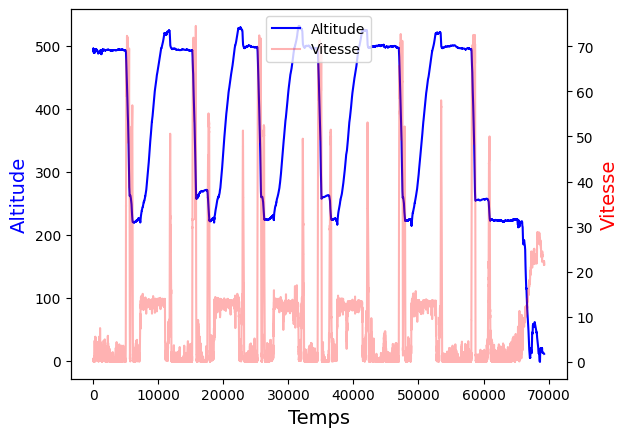

In [4]:

import matplotlib.pyplot as plt
#Graphique de l'atitude en focntion du temps
fig, ax = plt.subplots()
ax.plot(data['elevation[m]'][0:-1],"b")
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Altitude", color="blue", fontsize=14)
ax2 = ax.twinx()
ax2.plot(data['speed[km/h]'][0:-1],"r", alpha=0.3)
ax2.set_ylabel("Vitesse", color="red", fontsize=14)

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, ["Altitude", "Vitesse"], loc="upper center")

#plt.plot(data['elevation[m]'][0:-1])
#plt.plot(data['speed[km/h]'][0:-1]*7)
plt.show()

## Méthode de calcule du nombre de descentes avec scipy

In [5]:
import numpy as np
from scipy.signal import argrelmin,argrelmax

index_min_locaux=argrelmin(data['elevation[m]'].to_numpy(), order=4000)[0]
index_max_locaux=argrelmax(data['elevation[m]'].to_numpy(), order=4000)[0]
min_locaux=np.median(np.array([data['elevation[m]'][i] for i in index_min_locaux]))
max_locaux=np.median(np.array([data['elevation[m]'][i] for i in index_max_locaux]))


#On prend l'altitude max moins un delta de x mètres pour déterminer le début de la descente et on regarde combien de fois le skieur quitte cette zone
alt_max_zone=max_locaux-(max_locaux-min_locaux)/3
alt_min_zone=min_locaux+(max_locaux-min_locaux)/3

data_dans_les_zones_départ_et_arrivée=data[(data['elevation[m]']>alt_max_zone) | (data['elevation[m]']<alt_min_zone)]

L=np.diff(data_dans_les_zones_départ_et_arrivée['elevation[m]'].to_numpy())
zone_de_descente_large=[data_dans_les_zones_départ_et_arrivée[i:i+2].index for i in range(len(L)) if L[i]<-10 ]


In [6]:
alt_max_zone,alt_min_zone

(422.98333333333335, 321.0966666666667)

In [7]:
#Détection du départ et de l'arrivée
data_vitesse=data['speed[km/h]']
vitesse_seuil_bas=10
vitesse_seuil_haut=4
Liste_départ_arrivé_index=[]

#Initialisation
i=0
#detection debut
index=zone_de_descente_large[i][0]
index_debut=zone_de_descente_large[i][0]
while data_vitesse[index] >vitesse_seuil_haut and index!=0:
        index=index-1
index_debut=index
#detection fin
index=zone_de_descente_large[i][1]
index_fin=zone_de_descente_large[i][1]
while data_vitesse[index]>vitesse_seuil_bas and index<zone_de_descente_large[i+1][1]:
    index=index+1
index_fin=index
Liste_départ_arrivé_index.append([index_debut,index_fin])

#Recurrence
#Détéction début
for i in range(1,len(zone_de_descente_large)-1):
    index=zone_de_descente_large[i][0]
    index_debut=zone_de_descente_large[i][0]
    while data_vitesse[index] >vitesse_seuil_haut and index>zone_de_descente_large[i-1][1]:
        index=index-1
    index_debut=index
    #detection fin
    index=zone_de_descente_large[i][1]
    index_fin=zone_de_descente_large[i][1]
    while data_vitesse[index] >vitesse_seuil_bas and index<zone_de_descente_large[i+1][1]:
        index=index+1
    index_fin=index
    Liste_départ_arrivé_index.append([index_debut,index_fin])
#fin
#Détéction début
index=zone_de_descente_large[i+1][0]
index_debut=zone_de_descente_large[i+1][0]
while data_vitesse[index] >vitesse_seuil_haut and index>zone_de_descente_large[i][1]:
    index=index-1
index_debut=index
#detection fin
index=zone_de_descente_large[i+1][1]
index_fin=zone_de_descente_large[i+1][1]
while data_vitesse[index] >vitesse_seuil_bas and index<len(data_vitesse):
    index=index+1
index_fin=index
Liste_départ_arrivé_index.append([index_debut,index_fin])

## Checkpoints

In [8]:
#fonction convertie longitude et latitude en coordonnées cartésiennes
import numpy as np
from datetime import datetime
 
def intersection_4_points(x1,y1,x2,y2,x3,y3,x4,y4,option=False):
    v1x=x2-x1
    v1y=y2-y1
    v2x=x4-x3
    v2y=y4-y3
    if v1x*v2y-v1y*v2x==0:
        return False
    else: 
        t1=((x3-x1)*v2y-(y3-y1)*v2x)/(v1x*v2y-v1y*v2x)
        t2=-((x1-x3)*v1y-(y1-y3)*v1x)/(v1x*v2y-v1y*v2x)
        if t1>=0 and t1<=1 and t2>=0 and t2<=1:
            if option==False:
                return True
            else :
                return t1
        else:
            return False

def estimation_temps(index,t):

    Temps1=datetime.strptime(str(data['time[ISO-UTC]'][index-1]), '%Y%m%dT%H%M%S%f')
    temps2=datetime.strptime(str(data['time[ISO-UTC]'][index]), '%Y%m%dT%H%M%S%f')

    return Temps1+(temps2-Temps1)*t


In [9]:
len(Liste_départ_arrivé_index)

6

In [10]:
#x,y,z =coordonnées_mercator(data['Latitude[deg]'][5157:5159],data['Longitude[deg]'][5157:5159],data['elevation[m]'][5157:5159])

#intersection_4_points(x[0],y[0],x[1],y[1],coordonnées_points[1][0][0],coordonnées_points[1][0][1],coordonnées_points[1][1][0],coordonnées_points[1][1][1],option=True)

In [11]:
#Mise en place des temps intermédiaires entre chaque segments
import time
from scipy.interpolate import CubicSpline

def checkpoints_2_points(Liste_départ_arrivé_index,nbr_de_segments,descente_mère):
    longeure_vecteur=20
    liste_index=[]

    #Selection de la descente mère
    index_debut=Liste_départ_arrivé_index[descente_mère][0]
    index_fin=Liste_départ_arrivé_index[descente_mère][1]
    #Point de départ
    p0=np.array(coordonnées_mercator(data['Latitude[deg]'][index_debut],data['Longitude[deg]'][index_debut],data['elevation[m]'][index_debut]))[0:2]
    p0_apres=np.array(coordonnées_mercator(data['Latitude[deg]'][index_debut+1],data['Longitude[deg]'][index_debut+1],data['elevation[m]'][index_debut+1]))[0:2]
    p0_avant=np.array(coordonnées_mercator(data['Latitude[deg]'][index_debut-1],data['Longitude[deg]'][index_debut-1],data['elevation[m]'][index_debut-1]))[0:2]
    n0=(p0_apres-p0_avant)/np.linalg.norm(p0_apres-p0_avant)
    v1=np.array([1,-n0[0]/n0[1]])
    v1=v1/np.linalg.norm(v1)
    coordonnées_points=[[p0+longeure_vecteur*v1,p0-longeure_vecteur*v1]]
    liste_index.append(index_debut)
    for i in range(1,nbr_de_segments+1):
        index=index_debut+i*(index_fin-index_debut)//nbr_de_segments
        p0=np.array(coordonnées_mercator(data['Latitude[deg]'][index],data['Longitude[deg]'][index],data['elevation[m]'][index]))[0:2]
        p0_apres=np.array(coordonnées_mercator(data['Latitude[deg]'][index+1],data['Longitude[deg]'][index+1],data['elevation[m]'][index+1]))[0:2]
        p0_avant=np.array(coordonnées_mercator(data['Latitude[deg]'][index-1],data['Longitude[deg]'][index-1],data['elevation[m]'][index-1]))[0:2]
        n0=(p0_apres-p0_avant)/np.linalg.norm(p0_apres-p0_avant)
        v1=np.array([1,-n0[0]/n0[1]])
        v1=v1/np.linalg.norm(v1)
        coordonnées_points.append([p0+longeure_vecteur*v1,p0-longeure_vecteur*v1])
        liste_index.append(index)
    return coordonnées_points,liste_index


def temps_intermédiaires(Liste_départ_arrivé_index,data,liste_points_checkpoints):
    nbr_de_fois_plus_de_points=2
    liste_indices_final=[]
    commencement=0
    index_debut=Liste_départ_arrivé_index[0][0]-500
    index_fin=Liste_départ_arrivé_index[-1][1]+500
    x,y,z =coordonnées_mercator(data['Latitude[deg]'][index_debut:index_fin+1],data['Longitude[deg]'][index_debut:index_fin+1],data['elevation[m]'][index_debut:index_fin+1])
    vitesse=data['speed[km/h]'][index_debut:index_fin+1]
    A = np.c_[x,y,z,vitesse]
    temps= np.array([(datetime.strptime(str(data['time[ISO-UTC]'][index]), '%Y%m%dT%H%M%S%f') - datetime.strptime(str(data['time[ISO-UTC]'][0]), '%Y%m%dT%H%M%S%f')).total_seconds() for index in range(index_debut,index_fin+1)])
    T1=np.linspace(temps[0],temps[-1],len(temps)*nbr_de_fois_plus_de_points)
    cs = CubicSpline(temps, A)
    y2=cs(T1)
    x,y,z=y2[:,0],y2[:,1],y2[:,2]
    vitesse=y2[:,3]
    temps_intermédiaires_descentes=[]
    vitesse_intermédiaires=[]
    vitesse_final=[]
    temps_vitesse=[]
    temps_vitesse_final=[]
    trajectoire_final=[]
    for descente in range(len(Liste_départ_arrivé_index)):
        index=(Liste_départ_arrivé_index[descente][0]-500-index_debut)*nbr_de_fois_plus_de_points
        temps_intermédiaires=[]
        liste_indices=[]
        vitesse_intermédiaires=[]
        temps_vitesse=[]
        trajectoire=[]
        commencement=0
        for i in range(len(liste_points_checkpoints)):
            point1=liste_points_checkpoints[i][0]
            point2=liste_points_checkpoints[i][1]

            while intersection_4_points(x[index],y[index],x[index+1],y[index+1],point1[0],point1[1],point2[0],point2[1])==False:
                if commencement>0:
                    temps_vitesse.append(T1[index]-temps_intermédiaires[0])
                    vitesse_intermédiaires.append(vitesse[index])
                    trajectoire.append([x[index],y[index],z[index]])
                index=index+1
            liste_indices.append(index//2+index_debut)
            t=intersection_4_points(x[index],y[index],x[index+1],y[index+1],point1[0],point1[1],point2[0],point2[1],option=True)
            if commencement==0:
                vitesse_intermédiaires.append(vitesse[index]+(vitesse[index+1]-vitesse[index])*t)
                temps_vitesse.append(0)
                trajectoire.append([x[index]+(x[index+1]-x[index])*t,y[index]+(y[index+1]-y[index])*t,z[index]+(z[index+1]-z[index])*t])
            elif commencement==len(liste_points_checkpoints)-1 :
                vitesse_intermédiaires.append(vitesse[index]+(vitesse[index+1]-vitesse[index])*t)
                temps_vitesse.append(T1[index]+(T1[index+1]-T1[index])*t-temps_intermédiaires[0])
                trajectoire.append([x[index]+(x[index+1]-x[index])*t,y[index]+(y[index+1]-y[index])*t,z[index]+(z[index+1]-z[index])*t])
            temps_intermédiaires.append(T1[index]+(T1[index+1]-T1[index])*t)  
            index=index+1  
            commencement+=1
        liste_indices_final.append(liste_indices)
        temps_sections=[(temps_intermédiaires[i+1]-temps_intermédiaires[i]) for i in range(len(temps_intermédiaires)-1)]
        temps_intermédiaires_descentes.append(temps_sections)
        vitesse_final.append(vitesse_intermédiaires)
        temps_vitesse_final.append(temps_vitesse)
        trajectoire_final.append(trajectoire)
    return temps_intermédiaires_descentes,liste_indices_final,vitesse_final,temps_vitesse_final,trajectoire_final


def temps_intermédiaires_2(Liste_départ_arrivé_index,data,liste_points_checkpoints):
    liste_indices_final=[]
    index_debut=Liste_départ_arrivé_index[0][0]-500
    index_fin=Liste_départ_arrivé_index[-1][1]+500
    x,y,z =coordonnées_mercator(data['Latitude[deg]'][index_debut:index_fin],data['Longitude[deg]'][index_debut:index_fin],data['elevation[m]'][index_debut:index_fin])
    temps_intermédiaires_descentes=[]
    for descente in range(len(Liste_départ_arrivé_index)):
        index=Liste_départ_arrivé_index[descente][0]-500
        temps_intermédiaires=[]
        liste_indices=[]
        for i in range(len(liste_points_checkpoints)):
            point1=liste_points_checkpoints[i][0]
            point2=liste_points_checkpoints[i][1]

            while intersection_4_points(x[index-index_debut],y[index-index_debut],x[index-index_debut+1],y[index-index_debut+1],point1[0],point1[1],point2[0],point2[1])==False:
                index=index+1
            liste_indices.append(index)
            t=intersection_4_points(x[index-index_debut],y[index-index_debut],x[index-index_debut+1],y[index-index_debut+1],point1[0],point1[1],point2[0],point2[1],option=True)
            temps_intermédiaires.append(estimation_temps(index,t))    
        liste_indices_final.append(liste_indices)
        temps_sections=[(temps_intermédiaires[i+1]-temps_intermédiaires[i]).total_seconds() for i in range(len(temps_intermédiaires)-1)]
        temps_intermédiaires_descentes.append(temps_sections)
    return temps_intermédiaires_descentes,liste_indices_final


def ordonnancement_liste_points_checkpoints(Liste_départ_arrivé_index,data,liste_points_checkpoints):
    numéro_de_la_descente=1
    nouvelle_liste_points_checkpoints=[]
    index_debut=Liste_départ_arrivé_index[numéro_de_la_descente][0]-500
    index_fin=Liste_départ_arrivé_index[numéro_de_la_descente][1]+500
    x,y,z =coordonnées_mercator(data['Latitude[deg]'][index_debut:index_fin],data['Longitude[deg]'][index_debut:index_fin],data['elevation[m]'][index_debut:index_fin])
    liste_indices=[]
    for i in range(len(liste_points_checkpoints)):
        index=index_debut
        point1=liste_points_checkpoints[i][0]
        point2=liste_points_checkpoints[i][1]
        
        while intersection_4_points(x[index-index_debut],y[index-index_debut],x[index-index_debut+1],y[index-index_debut+1],point1[0],point1[1],point2[0],point2[1])==False:
            index=index+1

        liste_indices.append(index)

    indice=np.argsort(liste_indices)
    nouvelle_liste_points_checkpoints=[liste_points_checkpoints[i] for i in indice]

    return nouvelle_liste_points_checkpoints

def temps_total(temps_intermédiaires_variable):
    temps_total=[]
    for i in range(len(temps_intermédiaires_variable[0])):
        temps_total.append(sum(temps_intermédiaires_variable[0][i]))
    return temps_total



In [51]:
numéro_de_la_descente=2

In [13]:
coordonnées_points,liste=checkpoints_2_points(Liste_départ_arrivé_index,5,0)

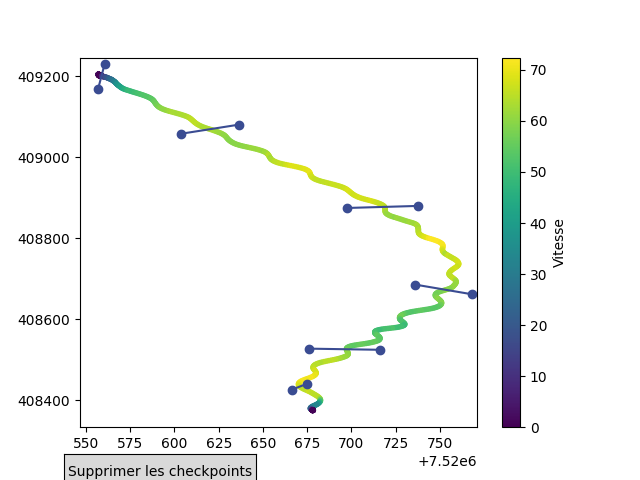

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from matplotlib.widgets import Button

%matplotlib widget 

points=[]
lines=[]


global num_points
num_points=0

color='#3A4C92'


#données
X = projection_mercator[1][Liste_départ_arrivé_index[numéro_de_la_descente][0]-500:Liste_départ_arrivé_index[numéro_de_la_descente][1]+50]
Y = projection_mercator[0][Liste_départ_arrivé_index[numéro_de_la_descente][0]-500:Liste_départ_arrivé_index[numéro_de_la_descente][1]+50]
v=data['speed[km/h]'][Liste_départ_arrivé_index[numéro_de_la_descente][0]-500:Liste_départ_arrivé_index[numéro_de_la_descente][1]+50]
max_X=max(X)
max_Y=max(Y)
min_X=min(X)
min_Y=min(Y)


fig, ax = plt.subplots()

# Utilisation d'un colormap pour associer une couleur à chaque valeur de vitesse
cmap = plt.get_cmap('viridis')
sc = ax.scatter(X, Y, c=v, cmap=cmap,marker='.')
# Ajout d'une barre de couleur pour indiquer les valeurs de vitesse
cbar = plt.colorbar(sc)
cbar.set_label('Vitesse')

#plt.plot(X, Y)
#for j, txt in enumerate(range(Liste_départ_arrivé_index[numéro_de_la_descente][0],Liste_départ_arrivé_index[numéro_de_la_descente][1])):
#    ax.annotate(txt, (X[j], Y[j]))


liste_points_checkpoints=coordonnées_points
#  Mise en place des checkpoints proposée
for i in range(len(liste_points_checkpoints)): 
    points.append(ax.plot(liste_points_checkpoints[i][0][1],liste_points_checkpoints[i][0][0], 'o' ,picker=True,color=color)[0])
    points.append(ax.plot(liste_points_checkpoints[i][1][1],liste_points_checkpoints[i][1][0], 'o' ,picker=True,color=color)[0])
    num_points+=2

    lines.append(ax.plot([liste_points_checkpoints[i][0][1],liste_points_checkpoints[i][1][1]],[liste_points_checkpoints[i][0][0],liste_points_checkpoints[i][1][0]],color=color))



ax.set_xlim(min_X-0.05*(max_X-min_X), max_X+0.05*(max_X-min_X))
ax.set_ylim(min_Y-0.05*(max_Y-min_Y), max_Y+0.05*(max_Y-min_Y))

# Fonction pour supprimer les checkpoints
def remove_checkpoints(b):
    global num_points
    num_points=0
    global points
    points=[]
    global lines
    lines=[]
    for line in ax.lines:
        line.remove()
    

class MoveGraphPoint(object):
    def __init__(self, ax):
        self.ax = ax
        self.figcanvas = self.ax.figure.canvas
        self.pressed = False
        self.start = False
        self.selected = False
        self.point = None
        self.figcanvas.mpl_connect('pick_event', self.pick_point)
        self.figcanvas.mpl_connect('button_press_event', self.mouse_press)
        self.figcanvas.mpl_connect('button_release_event', self.mouse_release)
        self.figcanvas.mpl_connect('motion_notify_event', self.mouse_move)
        self.figcanvas.mpl_connect('key_press_event', self.supprimer_point)

    
    # Fonction pour ajouter un point à chaque clic
    def add_point(self,event):
        # Vérifier si le clic est dans les limites du graphique
        global num_points
        self.point,=ax.plot([event.xdata], [event.ydata], 'o',picker=True,color=color)
        points.append(self.point)
        num_points+=1 
        if num_points%2==0:
            lines.append(ax.plot([points[-2].get_xdata(),points[-1].get_xdata()],[points[-2].get_ydata(),points[-1].get_ydata(),],color=color))
            
        fig.canvas.draw()

    def mouse_release(self, event):
        if self.ax.get_navigate_mode() != None: return
        if not event.inaxes: return
        if event.inaxes != self.ax: return
        if self.pressed:
            self.pressed = False
            self.start = False
            self.selected = False
            self.point.set_color(color)

            return

    def mouse_press(self, event):
        if self.ax.get_navigate_mode() != None: return
        if not event.inaxes: return
        if event.inaxes != self.ax: return
        if self.start: return
        if self.selected:
            self.pressed = True
        else : 
            self.add_point(event)

    def mouse_move(self, event):
        if self.ax.get_navigate_mode() != None: return
        if not event.inaxes: return
        if event.inaxes != self.ax: return
        if not self.pressed: return
        self.start = True

        self.point.set_xdata([event.xdata])
        self.point.set_ydata([event.ydata])

        indice=points.index(self.point)
        if indice%2==1:
            lines[indice//2][0].set_xdata([points[indice-1].get_xdata(),points[indice].get_xdata()])
            lines[indice//2][0].set_ydata([points[indice-1].get_ydata(),points[indice].get_ydata()])

        elif len(points)>indice+1:
            lines[indice//2][0].set_xdata([points[indice].get_xdata(),points[indice+1].get_xdata()])
            lines[indice//2][0].set_ydata([points[indice].get_ydata(),points[indice+1].get_ydata()])
        self.figcanvas.draw()

    def pick_point(self, event):
        if self.ax.get_navigate_mode() != None: return
        self.point=event.artist
        self.selected = True
        self.point.set_color('r')
        self.figcanvas.draw()
    def supprimer_point(self,event):
        if event.key == 'd'and self.start :
            if self.point in points:
                indice=points.index(self.point)
                #on vérifie que le point que l'on supprimer est relié à un autre point
                if len(lines)>indice//2:
                    lines[indice//2][0].remove()
                    lines.remove(lines[indice//2])
                    #mettre le point seul s'il était relié à la fin de la liste
                    if indice%2==1 :
                        point=points[indice-1]
                        points.remove(point)
                        points.append(point)
                    else: 
                        point=points[indice+1]
                        points.remove(point)
                        points.append(point)                    
                
                self.point.remove()
                points.remove(self.point)
                # on vérifie si il y a deux points non reliés à la fin de la liste
                if len(lines)<(len(points))//2:
                     lines.append(ax.plot([points[-2].get_xdata(),points[-1].get_xdata()],[points[-2].get_ydata(),points[-1].get_ydata(),],color=color))

                self.figcanvas.draw()
                global num_points
                num_points-=1
                self.pressed = False
                self.start = False
                self.selected = False


# Créer un bouton pour supprimer les checkpoints
axes = plt.axes([0.1, -0.02, 0.3, 0.075])
button = Button(axes,"Supprimer les checkpoints")
button.on_clicked(remove_checkpoints)

# Connecter la fonction à l'événement de clic
move_point=MoveGraphPoint(ax)
# Afficher le graphique
plt.show()

In [56]:
coordonnées_points=[[[points[i].get_ydata()[0],points[i].get_xdata()[0]],[points[i+1].get_ydata()[0],points[i+1].get_xdata()[0]]] for i in range(len(points)) if i%2==0]
coordonnées_points= ordonnancement_liste_points_checkpoints(Liste_départ_arrivé_index,data,coordonnées_points)
coordonnées_points

[[[409228.7699275625, 7520560.4561113035],
  [409168.14561398054, 7520556.806749414]],
 [[409080.164520333, 7520636.37742471],
  [409057.5075819365, 7520603.412850657]],
 [[408879.67185600137, 7520737.417666905],
  [408874.6497305974, 7520697.734191043]],
 [[408685.7060105406, 7520735.954593903],
  [408661.8239673601, 7520768.042722761]],
 [[408527.59643563686, 7520676.178995027],
  [408524.77678656636, 7520716.079491003]],
 [[408406.2668638776, 7520650.912291561],
  [408453.4253011218, 7520688.83504899]]]

In [57]:
Temps=temps_total(temps_intermédiaires(Liste_départ_arrivé_index,data,coordonnées_points))
print(Temps)

[54.53496342926087, 55.11820405190383, 55.45635906731832, 54.44561912555491, 54.67123128100775, 54.62617000032333]


In [44]:
import pyproj
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import interactive
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d.art3d import LineCollection



#descente
numéro_de_la_descente=0



fig = make_subplots(
    rows=1, cols=2,specs=[[{'type': 'scene'},{'type': 'scene'}]])

longeur_plan=20

liste_points_checkpoints,liste_indice=checkpoints_2_points(Liste_départ_arrivé_index,4,2)

for i in range(len(liste_points_checkpoints)) :
    
    point_1=np.array([liste_points_checkpoints[i][0][0],liste_points_checkpoints[i][0][1],data['elevation[m]'][liste_indice[i]]+longeur_plan])
    point_2=np.array([liste_points_checkpoints[i][1][0],liste_points_checkpoints[i][1][1],data['elevation[m]'][liste_indice[i]]+longeur_plan])
    point_3=np.array([liste_points_checkpoints[i][0][0],liste_points_checkpoints[i][0][1]+0.001,data['elevation[m]'][liste_indice[i]]-longeur_plan])
    point_4=np.array([liste_points_checkpoints[i][1][0],liste_points_checkpoints[i][1][1]+0.001,data['elevation[m]'][liste_indice[i]]-longeur_plan])

    x = [point_1[0], point_2[0],point_3[0],point_4[0]]
    y = [point_1[1], point_2[1],point_3[1],point_4[1]]
    z = [point_1[2], point_2[2],point_3[2],point_4[2]]
    
    fig.add_trace(go.Mesh3d(x=x, y=y, z=z,),row=1, col=1)



vitesse=data['speed[km/h]'][Liste_départ_arrivé_index[numéro_de_la_descente][0]:Liste_départ_arrivé_index[numéro_de_la_descente][1]]
Lat=data['Latitude[deg]'][Liste_départ_arrivé_index[numéro_de_la_descente][0]:Liste_départ_arrivé_index[numéro_de_la_descente][1]].to_numpy()
Long=data['Longitude[deg]'][Liste_départ_arrivé_index[numéro_de_la_descente][0]:Liste_départ_arrivé_index[numéro_de_la_descente][1]].to_numpy()
elevation=data['elevation[m]'][Liste_départ_arrivé_index[numéro_de_la_descente][0]:Liste_départ_arrivé_index[numéro_de_la_descente][1]].to_numpy()


x ,y, z = coordonnées_mercator(Lat,Long,elevation)


fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=2,color=vitesse,colorscale='Viridis',opacity=0.8)),row=1, col=1)
fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=2,color=vitesse,colorscale='Viridis',opacity=0.8)),row=1, col=2)

scene = dict(
        xaxis = dict(nticks=10, range=[x.min()-50*(x.max()-x.min()),x.max()+0.10*(x.max()-x.min())],),
        yaxis = dict(nticks=10, range=[y.min()-0.50*(y.max()-y.min()),y.max()+0.10*(y.max()-y.min())],),
        zaxis = dict(nticks=10, range=[z.min(),z.max()],),
        )

fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=600,
    width=1000,
    #scene=scene,

)
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=1),xaxis_title='x',yaxis_title='y',zaxis_title='z'),scene2=dict(aspectratio=dict(x=1, y=1, z=1),xaxis_title='x',yaxis_title='y',zaxis_title='z'))

fig.show()

## Visualisation des virages

In [18]:
trajectoire=temps_intermédiaires(Liste_départ_arrivé_index,data,coordonnées_points)[4]
vitesse=temps_intermédiaires(Liste_départ_arrivé_index,data,coordonnées_points)[2]
trajectoire=[np.array(trajectoire[i]).T for i in range(len(trajectoire))]

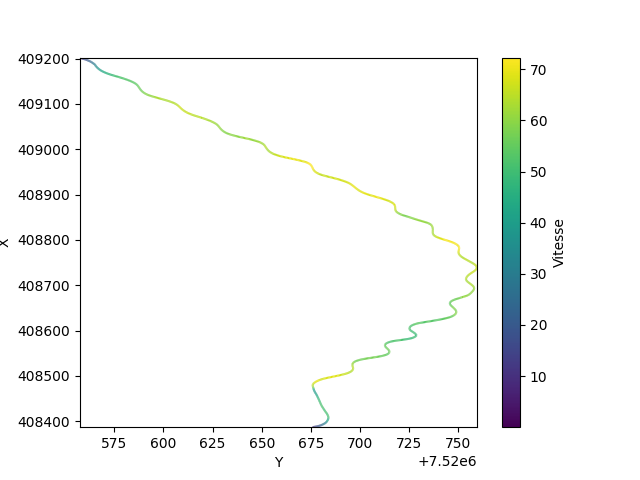

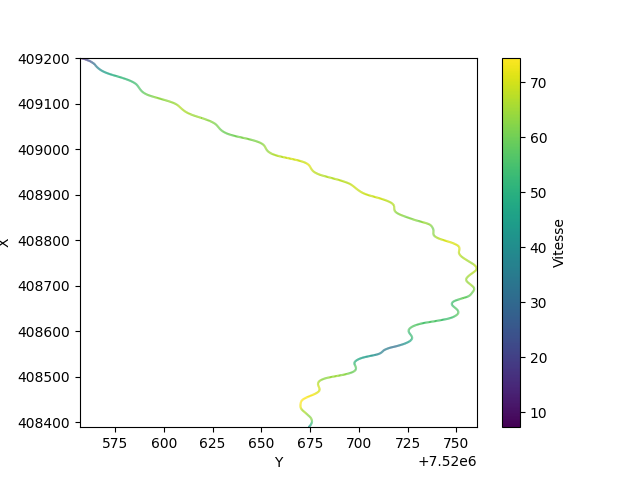

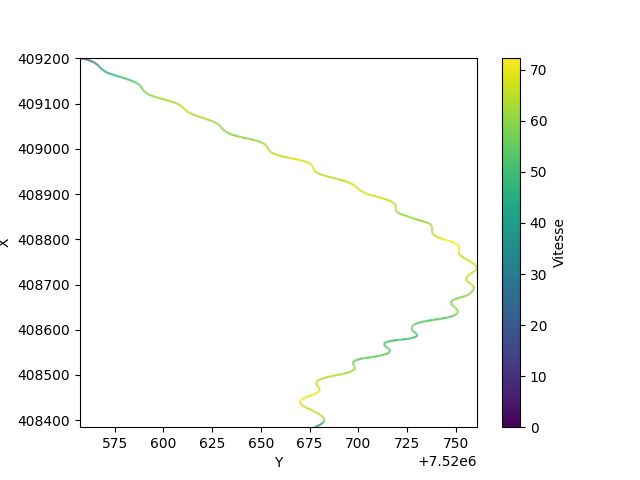

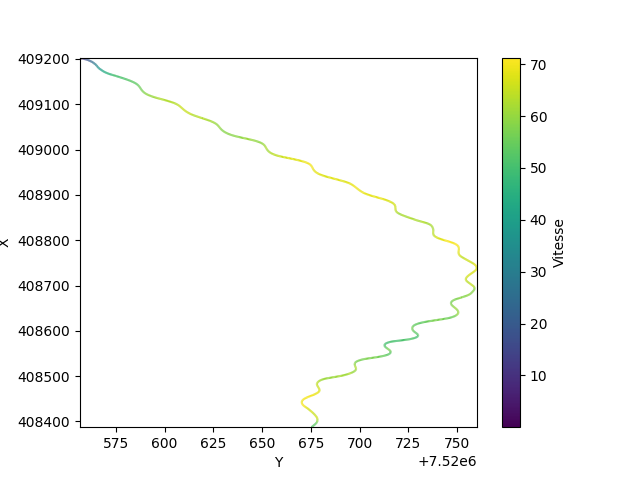

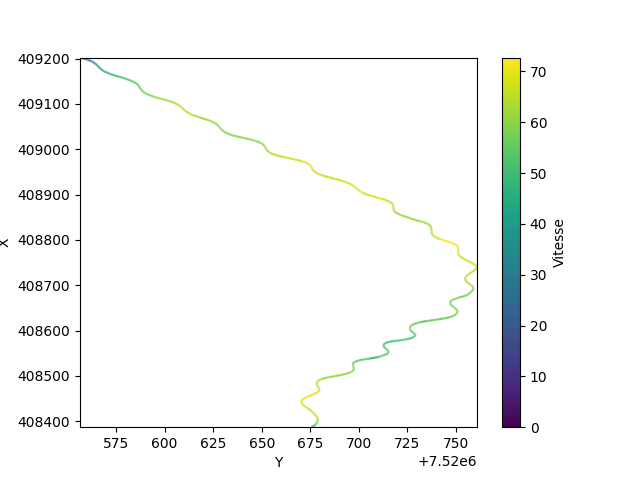

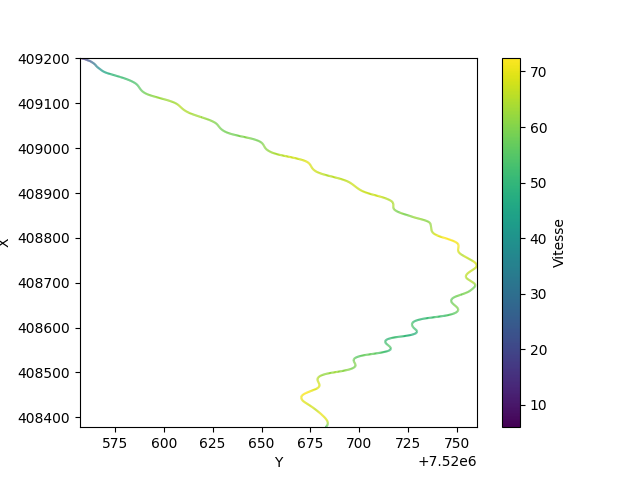

In [19]:
#%matplotlib inline
#%matplotlib widget

#Graphique en 2 dimensions projection mercator
for i in range(len(Liste_départ_arrivé_index)) :
    
    fig, axes = plt.subplots()
    axes.set_xlabel("Y")
    axes.set_ylabel("X")
    segments = [np.column_stack([trajectoire[i][1][j:j+2],trajectoire[i][0][j:j+2]]) for j in range(len(trajectoire[i][0])-1 )]
    lc = LineCollection(segments, cmap='viridis',array=vitesse[i])
    axes.axis([trajectoire[i][1].min(),trajectoire[i][1].max(),trajectoire[i][0].min(),trajectoire[i][0].max()]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]
    line = axes.add_collection(lc)
    plt.colorbar(line, label='Vitesse')

    plt.show()


In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


fig = make_subplots(
    rows=(len(Liste_départ_arrivé_index)-1)//3+1, cols=3,specs=[[{'type': 'scene'}]*3]*((len(Liste_départ_arrivé_index)-1)//3+1))

longeur_plan=30

liste_points_checkpoints,liste_indice=checkpoints_2_points(Liste_départ_arrivé_index,4,2)

for i in range(len(liste_points_checkpoints)) :
        
    point_1=np.array([liste_points_checkpoints[i][0][0],liste_points_checkpoints[i][0][1],data['elevation[m]'][liste_indice[i]]+longeur_plan])
    point_2=np.array([liste_points_checkpoints[i][1][0],liste_points_checkpoints[i][1][1],data['elevation[m]'][liste_indice[i]]+longeur_plan])
    point_3=np.array([liste_points_checkpoints[i][0][0],liste_points_checkpoints[i][0][1]+0.001,data['elevation[m]'][liste_indice[i]]-longeur_plan])
    point_4=np.array([liste_points_checkpoints[i][1][0],liste_points_checkpoints[i][1][1]+0.001,data['elevation[m]'][liste_indice[i]]-longeur_plan])

    x = [point_1[0], point_2[0],point_3[0],point_4[0]]
    y = [point_1[1], point_2[1],point_3[1],point_4[1]]
    z = [point_1[2], point_2[2],point_3[2],point_4[2]]
    for j in range(len(Liste_départ_arrivé_index)) :
        fig.add_trace(go.Mesh3d(x=x, y=y, z=z,),row=(j)//3+1, col=(j)%3+1)


for i in range(len(Liste_départ_arrivé_index)):
    # Read data from a csv
    x=trajectoire[i][0]
    y=trajectoire[i][1]
    z=trajectoire[i][2]
    
    fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=2,color=vitesse[i],colorscale='Viridis',opacity=0.8)),row=(i)//3+1, col=(i)%3+1)

scene = dict(
        xaxis = dict(nticks=10, range=[x.min()-0.50*(x.max()-x.min()),x.max()+0.10*(x.max()-x.min())],),
        yaxis = dict(nticks=10, range=[y.min()-0.50*(y.max()-y.min()),y.max()+0.10*(y.max()-y.min())],),
        zaxis = dict(nticks=10, range=[z.min(),z.max()],),
        )

fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=600,
    width=1000,


)
scene=dict(aspectratio=dict(x=1, y=1, z=1),xaxis_title='x',yaxis_title='y',zaxis_title='z')
fig.update_layout(scene=scene,scene2=scene,scene3=scene,scene4=scene,scene5=scene,scene6=scene)


fig.show()

## Détéction de virages

In [72]:
def detection_virage_mercator(data,indices,numéro_de_la_descente,step=9,angle_limite=170):
  # SG step = 
  # SL step = 4  angle limite = 175
  # GS step = 9   angle limite = 172


  index_debut=indices[numéro_de_la_descente][0]
  index_fin=indices[numéro_de_la_descente][-1]

  lat=data['Latitude[deg]'][index_debut:index_fin].to_numpy()
  long=data['Longitude[deg]'][index_debut:index_fin].to_numpy()
  elevation=data['elevation[m]'][index_debut:index_fin].to_numpy()
  lat,long,elevation=coordonnées_mercator(lat,long,elevation)

  liste_index_debut=[]
  liste_index_fin=[]
  liste_index_angle_max=[]
  liste_angle_max=[]
  liste_angle_total=[]
  liste_angle_total_indice=[]
  virage=False
  for i in range(step,len(lat)-step):
    vec1=np.array([lat[i-step]-lat[i],long[i-step]-long[i]])
    vec2=np.array([lat[i+step]-lat[i],long[i+step]-long[i]])
    angle=np.arccos(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
    angle=angle*180/np.pi
    liste_angle_total.append(angle)
    liste_angle_total_indice.append(i)
    if angle<angle_limite and virage==False:
      liste_index_debut.append(i)
      liste_angle_max.append(angle)
      liste_index_angle_max.append(i)
      virage=True
    elif angle>angle_limite and virage==True:
      virage=False
      liste_index_fin.append(i)
    elif virage==True and angle<angle_limite and liste_angle_max[-1]>angle :
      liste_angle_max[-1]=angle
      liste_index_angle_max[-1]=i
  if virage==True :
    liste_index_fin.append(i)
  if liste_index_debut[-1]==liste_index_fin[-1]:
    liste_index_fin.pop()
    liste_angle_max.pop()
    liste_index_angle_max.pop()
    liste_index_debut.pop()

  return liste_index_debut,liste_index_fin,liste_index_angle_max,liste_angle_max,liste_angle_total,liste_angle_total_indice

In [73]:
indices=temps_intermédiaires_2(Liste_départ_arrivé_index,data,coordonnées_points)[1]

numéro_de_la_descente=2
step=9
angle_limite=172
print(detection_virage_mercator(data,indices,numéro_de_la_descente,4,175)[0])
print(detection_virage_mercator(data,indices,numéro_de_la_descente,4,175)[1])
print(detection_virage_mercator(data,indices,numéro_de_la_descente,4,175)[2])
#print(detection_virage_mercator(data,indices,numéro_de_la_descente,7,125)[3])
print(len(detection_virage_mercator(data,indices,numéro_de_la_descente,step,angle_limite)[0]))
print(len(detection_virage_mercator(data,indices,numéro_de_la_descente,4,175)[1]))
angle_totaux_mercator,angle_totaux_mercator_indice=detection_virage_mercator(data,indices,numéro_de_la_descente,step,angle_limite)[4:6]
angle_totaux_mercator_2,angle_totaux_mercator_indice_2=detection_virage_mercator(data,indices,numéro_de_la_descente,4,175)[4:6]

[8, 14, 24, 32, 47, 65, 82, 99, 112, 125, 138, 155, 170, 185, 198, 214, 227, 239, 253, 272, 286, 298, 311, 325, 340, 353, 372, 388, 409, 433, 449, 466, 485, 500, 516, 532, 544]
[12, 19, 28, 35, 54, 76, 94, 107, 120, 135, 151, 167, 182, 196, 209, 223, 236, 251, 263, 281, 297, 309, 319, 337, 351, 371, 384, 405, 430, 447, 464, 482, 497, 514, 530, 543, 550]
[10, 15, 26, 33, 50, 72, 88, 103, 116, 131, 146, 161, 177, 191, 203, 218, 232, 246, 258, 276, 291, 304, 315, 333, 346, 367, 377, 400, 417, 438, 456, 472, 491, 504, 522, 537, 549]
35
37


In [23]:
len(angle_totaux_mercator)

916

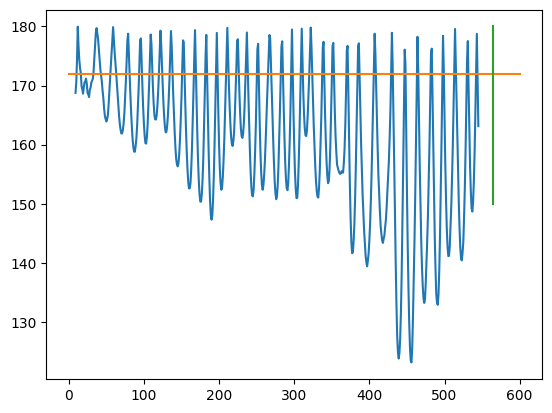

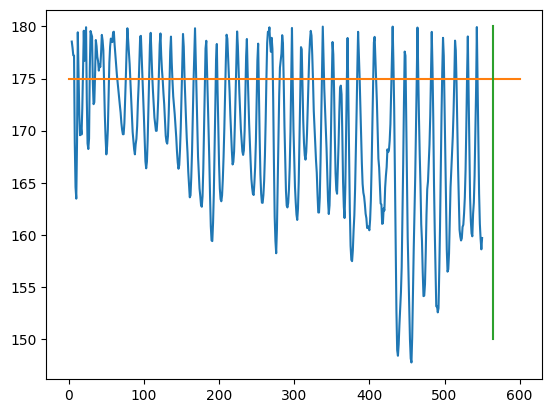

In [75]:
import matplotlib.pyplot as plt
# l'inverse de %matplotlib widget
%matplotlib inline
plt.plot(angle_totaux_mercator_indice,angle_totaux_mercator)
plt.plot([0,600],[172,172])
plt.plot([564,564],[150,180])
plt.show()
plt.plot(angle_totaux_mercator_indice_2,angle_totaux_mercator_2)
plt.plot([0,600],[175,175])
plt.plot([564,564],[150,180])
plt.show()

35


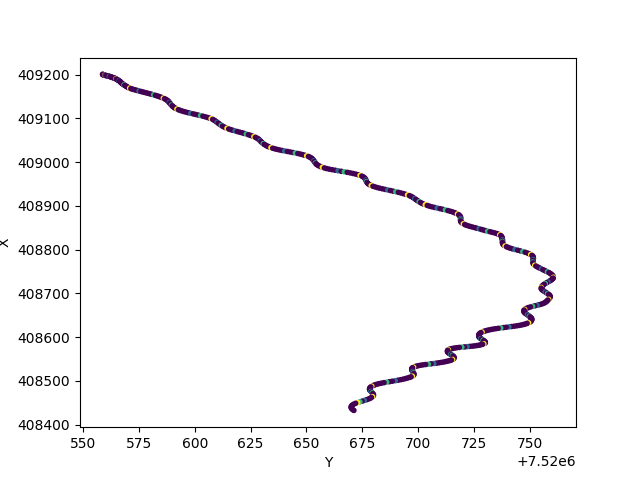

In [76]:
%matplotlib widget
from mpl_toolkits.mplot3d.art3d import LineCollection

numéro_de_la_descente=2

index_debut=indices[numéro_de_la_descente][0]
index_fin=indices[numéro_de_la_descente][-1]

Y=projection_mercator[0][index_debut:index_fin+1]
X=projection_mercator[1][index_debut:index_fin+1]


#markeur_temporel=[1 if i%4==0 else 0 for i in range(len(markeur_temporel))]
index_virage_debut,index_virage_fin,index_angle_max=detection_virage_mercator(data,indices,numéro_de_la_descente,9,172)[0:3]
markeur_temporel=[600 if i in index_angle_max else 400 if i in index_virage_debut else 200 if i in index_virage_fin else 0 for i in range(len(Y))]
fig, axes = plt.subplots()


sc = axes.scatter(X, Y, c=markeur_temporel,marker='.',cmap='viridis')
# Ajout d'une barre de couleur pour indiquer les valeurs de vitesse

axes.set_xlabel("Y")
axes.set_ylabel("X")

print(len(index_virage_debut))

plt.colorbar(line)
plt.show()  

In [26]:
len(index_virage_debut)

62

## Visualisation des vitesses et des puissances

In [27]:
def statistiques(data,indices):
    # Vitesse moyenne 
    vitesse_moyenne=[]
    vitesse_max=[]
    temps_total=[]
    distance=[]
    for i in range(len(indices)):
        vitesse_moyenne.append(np.mean(data['speed[km/h]'][indices[i][0]:indices[i][-1]]))
    # Vitesse max
        vitesse_max.append(np.max(data['speed[km/h]'][indices[i][0]:indices[i][-1]]))
    #Temps total
        temps_total.append((datetime.strptime(str(data['time[ISO-UTC]'][indices[i][-1]]), '%Y%m%dT%H%M%S%f')-datetime.strptime(str(data['time[ISO-UTC]'][indices[i][0]]), '%Y%m%dT%H%M%S%f')).total_seconds())
    #Distance
        distance.append(data['distance[m]'][indices[i][-1]]-data['distance[m]'][indices[i][0]])
    return vitesse_moyenne,vitesse_max,temps_total,distance

vitesse_moyenne,vitesse_max,temps_total_var,distance=statistiques(data,indices)

In [28]:
print("Vitesse moyenne : ",vitesse_moyenne)
print("Vitesse max : ",vitesse_max)
print("Temps total : ",temps_total_var)
print("Distance parcourue : ",distance)


Vitesse moyenne :  [36.62881720430108, 57.17904599659284, 34.05207920792079, 32.42915479582146, 32.384862819299904, 58.18452380952381]
Vitesse max :  [72.3, 74.5, 72.4, 71.3, 72.7, 72.5]
Temps total :  [93.0, 58.7, 101.0, 105.3, 105.7, 58.799]
Distance parcourue :  [954.07, 938.2800000000002, 964.0, 958.869999999999, 960.0699999999997, 957.5400000000009]


In [29]:
from datetime import datetime

#Puissance = delta_t/delta_h j+1-j
Puissance=[]
Elevation=[]
Elevation_vitesse=[]
Vitesse=[]
for i in range(len(Liste_départ_arrivé_index)) :
    puissance=[]
    elevation=[]
    vitesse=[]
    elevation_vitesse=[]
    for j in range(Liste_départ_arrivé_index[i][0]+1,Liste_départ_arrivé_index[i][1]+1):
        vitesse.append(data['speed[km/h]'][j])
        elevation_vitesse.append(data['elevation[m]'][j])
        delta_t=(datetime.strptime(str(data['time[ISO-UTC]'][j]), '%Y%m%dT%H%M%S%f')-datetime.strptime(str(data['time[ISO-UTC]'][j-1]), '%Y%m%dT%H%M%S%f')).total_seconds()
        delta_h=data['elevation[m]'][j-1]-data['elevation[m]'][j]
        if delta_h!=0:
            puissance.append(delta_t/(delta_h))
            elevation.append(data['elevation[m]'][j])
    Puissance.append(puissance)
    Elevation.append(elevation)
    Vitesse.append(vitesse)
    Elevation_vitesse.append(elevation_vitesse)

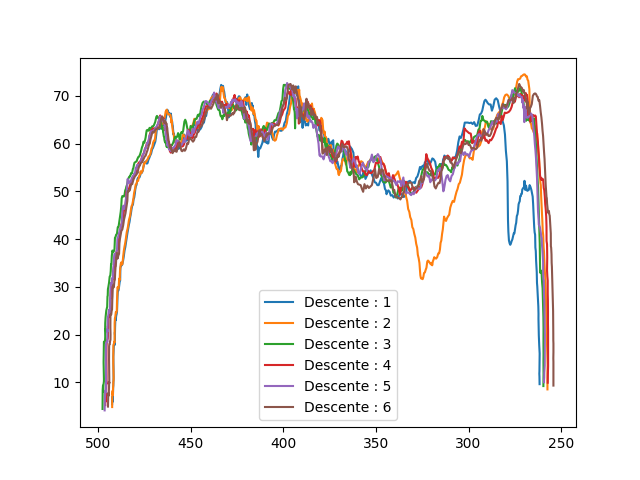

In [30]:
fig,axe = plt.subplots()
for i in range(len(Vitesse)):
    axe.plot(Elevation_vitesse[i],Vitesse[i],label=f'Descente : {i+1}')
    axe.xaxis.set_inverted(True)
    

plt.legend()
plt.show()

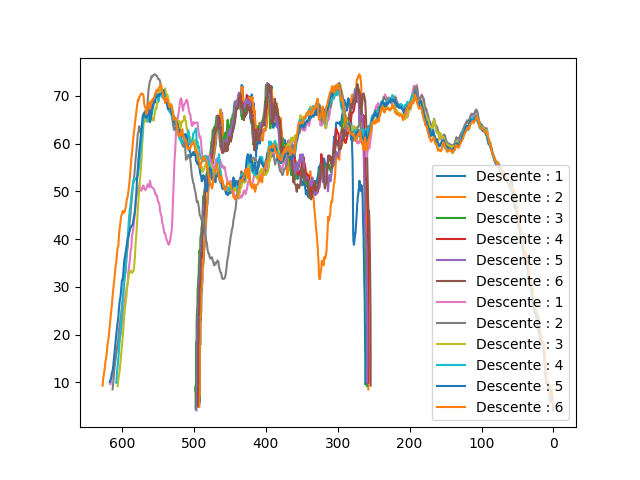

In [31]:
for i in range(len(Vitesse)):
    plt.plot(Vitesse[i],label=f'Descente : {i+1}')
   
plt.legend()
plt.show()

## Comparaison des trajectoires

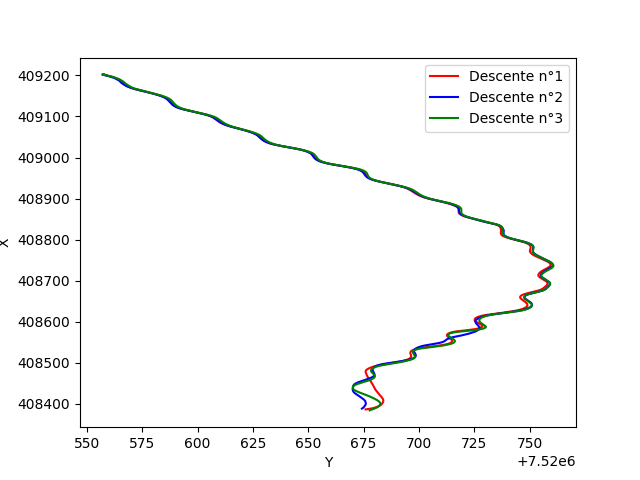

In [77]:
#%matplotlib inline
%matplotlib widget
from mpl_toolkits.mplot3d.art3d import LineCollection
#Graphique en 2 dimensions projection mercator
fig, axes = plt.subplots()
trajectoire_a_comparer=[0,1,2]
color=['r','b','g','y','c','m']
for k,i in enumerate(trajectoire_a_comparer):
    #fig, ax = plt.subplots()
    
    axes.set_xlabel("Y")
    axes.set_ylabel("X")

    axes.plot(trajectoire[i][1],trajectoire[i][0],label=f'Descente n°{i+1}',color=color[k])

    #ax.plot(projection_mercator[1][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]],projection_mercator[0][Liste_départ_arrivé_index[i][0]:Liste_départ_arrivé_index[i][1]],"b")
    #ax.set_xlabel("Y", fontsize=14)
    #ax.set_ylabel("X", color="blue", fontsize=14)
    #ax2 = ax.twinx()
plt.legend()   
plt.show()